In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets, linear_model, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [102]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [103]:
trainData=train.copy()
testData=test.copy()

In [104]:
trainData.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [105]:
testData.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Counting the unique elements in each column of the data frame

In [106]:
trainData.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [107]:
# we have to replace all the spaces in the rows as when we want to convert the ordinal features in map it does not work with spaces
trainData.replace('\s+', '_',regex=True,inplace=True)
testData.replace('\s+', '_',regex=True,inplace=True)

converting the ordinal features to categorical features

In [108]:
obj_col = trainData.columns[trainData.dtypes == 'object'].values
#select non object columns
num_col = trainData.columns[trainData.dtypes != 'object'].values


In [109]:
print(obj_col)

['Item_Identifier' 'Item_Fat_Content' 'Item_Type' 'Outlet_Identifier'
 'Outlet_Size' 'Outlet_Location_Type' 'Outlet_Type']


The columns above are the categorical features which have to be encoded

In [110]:
#labels = data['Item_Fat_Content'].astype('category').cat.categories.tolist()
#itemFatMap = {'Item_Fat_Content' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
itemFatMap= {'LF': 1, 'Low_Fat': 1, 'Regular': 2, 'low_fat': 1, 'reg': 2}
labels = trainData['Item_Type'].astype('category').cat.categories.tolist()
itemTypeMap = {'Item_Type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = trainData['Outlet_Identifier'].astype('category').cat.categories.tolist()
outletIdentifierMap = {'Outlet_Identifier' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = trainData['Outlet_Size'].astype('category').cat.categories.tolist()
outletSizeMap = {'Outlet_Size' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = trainData['Outlet_Location_Type'].astype('category').cat.categories.tolist()
outletLocationMap = {'Outlet_Location_Type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = trainData['Outlet_Type'].astype('category').cat.categories.tolist()
outletTypeMap = {'Outlet_Type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}


In [111]:
print(itemFatMap)
print(itemTypeMap)
print(outletIdentifierMap)
print(outletSizeMap)
print(outletLocationMap)
print(outletTypeMap)

{'LF': 1, 'Low_Fat': 1, 'Regular': 2, 'low_fat': 1, 'reg': 2}
{'Item_Type': {'Baking_Goods': 1, 'Breads': 2, 'Breakfast': 3, 'Canned': 4, 'Dairy': 5, 'Frozen_Foods': 6, 'Fruits_and_Vegetables': 7, 'Hard_Drinks': 8, 'Health_and_Hygiene': 9, 'Household': 10, 'Meat': 11, 'Others': 12, 'Seafood': 13, 'Snack_Foods': 14, 'Soft_Drinks': 15, 'Starchy_Foods': 16}}
{'Outlet_Identifier': {'OUT010': 1, 'OUT013': 2, 'OUT017': 3, 'OUT018': 4, 'OUT019': 5, 'OUT027': 6, 'OUT035': 7, 'OUT045': 8, 'OUT046': 9, 'OUT049': 10}}
{'Outlet_Size': {'High': 1, 'Medium': 2, 'Small': 3}}
{'Outlet_Location_Type': {'Tier_1': 1, 'Tier_2': 2, 'Tier_3': 3}}
{'Outlet_Type': {'Grocery_Store': 1, 'Supermarket_Type1': 2, 'Supermarket_Type2': 3, 'Supermarket_Type3': 4}}


In [112]:

trainData["Item_Fat_Content"] = trainData["Item_Fat_Content"].map(itemFatMap)
trainData.replace(itemTypeMap, inplace=True)
trainData.replace(outletIdentifierMap, inplace=True)
trainData.replace(outletSizeMap, inplace=True)
trainData.replace(outletLocationMap, inplace=True)
trainData.replace(outletTypeMap, inplace=True)


In [113]:
testData["Item_Fat_Content"] = testData["Item_Fat_Content"].map(itemFatMap)
testData.replace(itemTypeMap, inplace=True)
testData.replace(outletIdentifierMap, inplace=True)
testData.replace(outletSizeMap, inplace=True)
testData.replace(outletLocationMap, inplace=True)
testData.replace(outletTypeMap, inplace=True)

In [114]:
trainData.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,1,0.016047,5,249.8092,10,1999,2.0,1,2,3735.1380
1,DRC01,5.92,2,0.019278,15,48.2692,4,2009,2.0,3,3,443.4228
2,FDN15,17.50,1,0.016760,11,141.6180,10,1999,2.0,1,2,2097.2700
3,FDX07,19.20,2,0.000000,7,182.0950,1,1998,NaN,3,1,732.3800
4,NCD19,8.93,1,0.000000,10,53.8614,2,1987,1.0,3,2,994.7052


checking for null values 

In [115]:
trainData.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [116]:
newData=trainData.copy() # making a copy of the original encoded data 

In [117]:
trainData.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [118]:
newData.drop(['Item_Identifier'], axis=1, inplace=True)

In [119]:
newData.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

In [120]:
#filling nan 
newData['Item_Weight'] = newData['Item_Weight'].fillna((newData['Item_Weight'].mode()))
newData['Outlet_Size'] = newData['Outlet_Size'].fillna((newData['Outlet_Size'].mode()[0]))


testData['Item_Weight'] = testData['Item_Weight'].fillna((testData['Item_Weight'].mode()))
testData['Outlet_Size'] = testData['Outlet_Size'].fillna((testData['Outlet_Size'].mode()[0]))


In [121]:
newData.describe()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,1.352693,0.066132,8.226681,140.992782,5.722281,1997.831867,2.170832,2.112871,2.201220,2181.288914
std,4.643456,0.477836,0.051598,4.209990,62.275067,2.837201,8.371760,0.600327,0.812757,0.796459,1706.499616
min,4.555000,1.000000,0.000000,1.000000,31.290000,1.000000,1985.000000,1.000000,1.000000,1.000000,33.290000
25%,8.773750,1.000000,0.026989,5.000000,93.826500,3.000000,1987.000000,2.000000,1.000000,2.000000,834.247400
50%,12.600000,1.000000,0.053931,7.000000,143.012800,6.000000,1999.000000,2.000000,2.000000,2.000000,1794.331000
75%,16.850000,2.000000,0.094585,11.000000,185.643700,8.000000,2004.000000,3.000000,3.000000,2.000000,3101.296400
max,21.350000,2.000000,0.328391,16.000000,266.888400,10.000000,2009.000000,3.000000,3.000000,4.000000,13086.964800


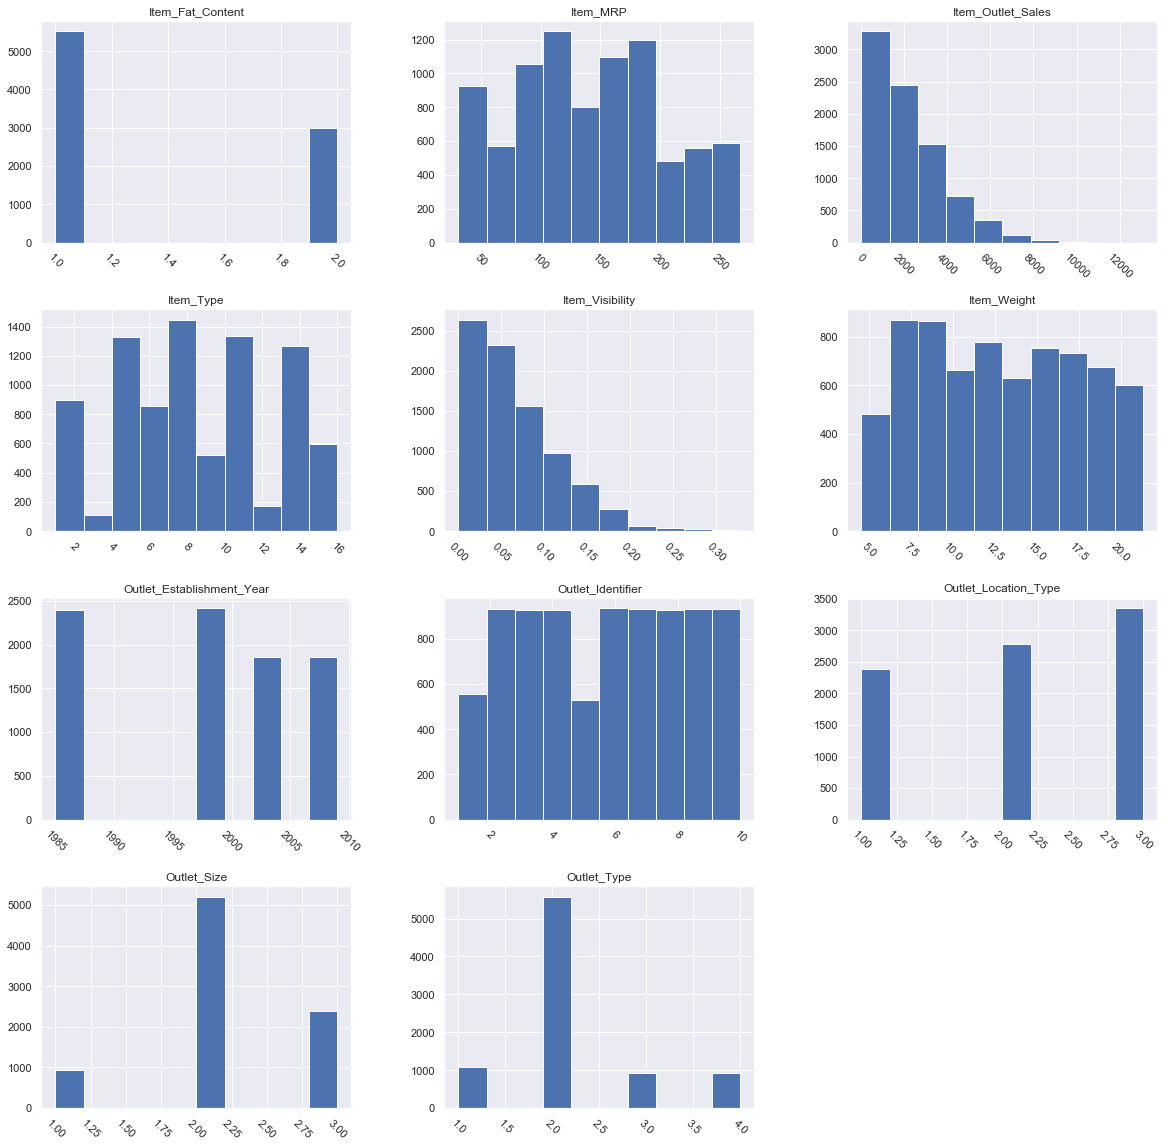

In [122]:
# Plot histogram grid
newData.hist(figsize=(20,20), xrot=-45)

# Clear the text "residue"
plt.show()

In [123]:
newData.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

# Item fat content

(array([5517.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3006.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

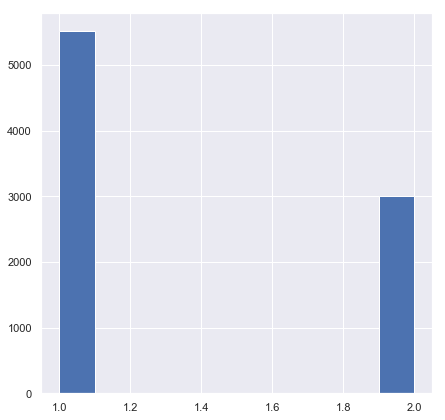

In [124]:
plt.hist(newData.Item_Fat_Content)

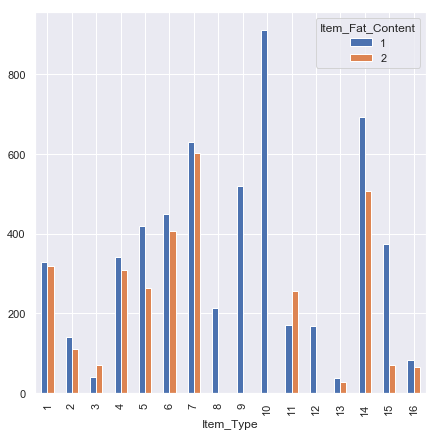

In [125]:
pd.crosstab(newData.Item_Type,newData.Item_Fat_Content).plot(kind='bar')

we can observe here that the item type 8,9 and 12 have only low fat content while all other have both low fat and regular fat category

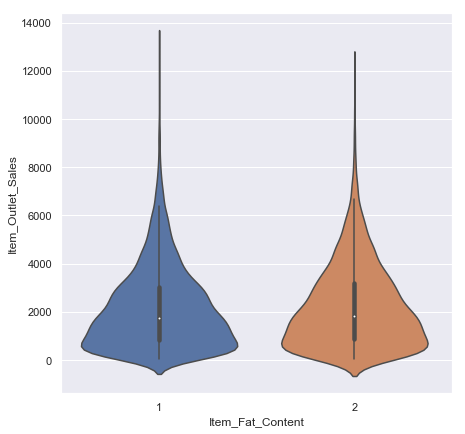

In [126]:
sns.violinplot(y="Item_Outlet_Sales", x="Item_Fat_Content", data=newData)

The sales of the items based on thier fat content is also similar as we can see both the item types (based on fat content) have similar sales distribution

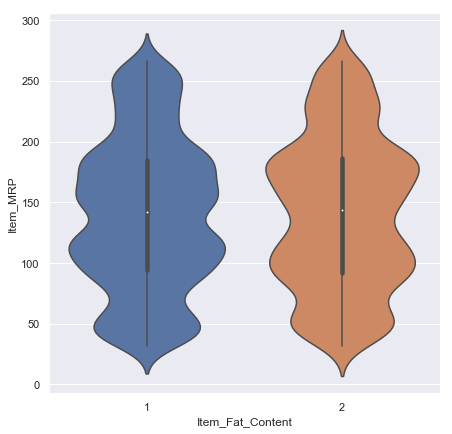

In [127]:
sns.violinplot(y="Item_MRP", x="Item_Fat_Content", data=newData)

The item mrp fot both the low fat and regular fat items are similarly distributed 

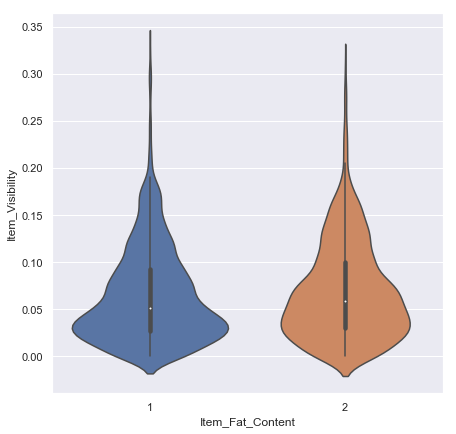

In [128]:
sns.violinplot(y="Item_Visibility", x="Item_Fat_Content", data=newData)

The visibility of the is dependedt on the fat content and varies as we can observe slight variation in the spread of the visibility distribution of items with different fat content

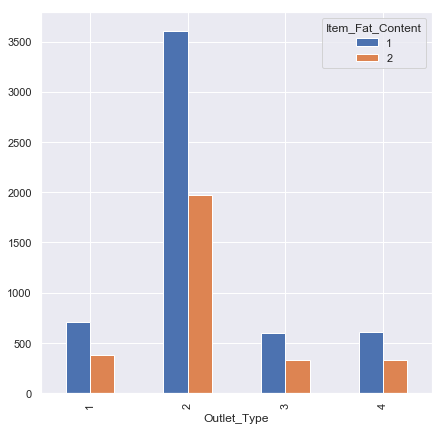

In [129]:
pd.crosstab(newData.Outlet_Type,newData.Item_Fat_Content).plot(kind='bar')

All the types of outlets have more fraction of low fat content products then the regular fat content products, even some outlet being grocery stores and some being supermarkets

# Item weight

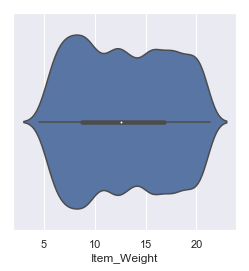

In [132]:
sns.set(rc={'figure.figsize':(4,4)})
sns.violinplot(newData['Item_Weight'])

we can observe the weight distribution of the items in the market, the mean weight is around 12.5 as we have replaced the nan values with mean weight the proportion around the mean weight have increased 

In [133]:
sns.set(rc={'figure.figsize':(12,8)})

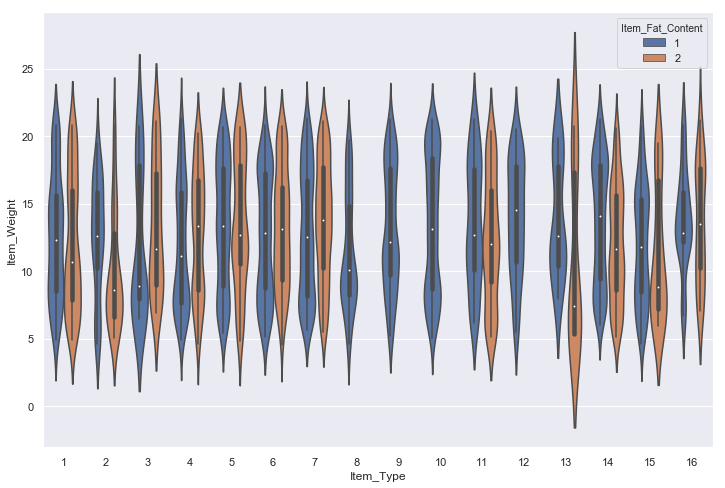

In [134]:
sns.violinplot(y="Item_Weight", x="Item_Type",hue="Item_Fat_Content", data=newData)

All the types of item in the (iten_type) have similar weight distribution with most of the item types having the mean item weight in the range (10-15) of item weight 


We can observe that the item type 8,9,10,12 have only item_fat_content of 1 (ie low_fat)

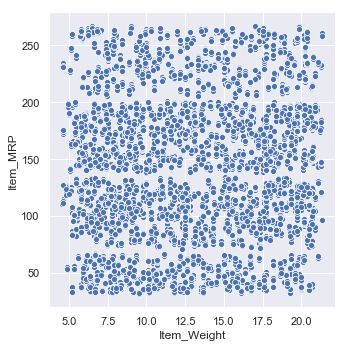

In [135]:
sns.set(rc={'figure.figsize':(7,7)})
sns.relplot(x="Item_Weight", y="Item_MRP", data=newData);

The item weight and mrp are not showing any significant linear relationship.

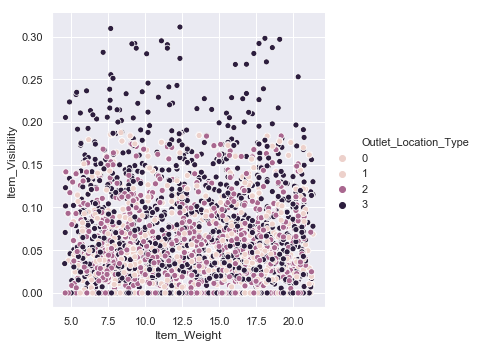

In [136]:

sns.relplot(x="Item_Weight", y="Item_Visibility",hue="Outlet_Location_Type",  data=newData)

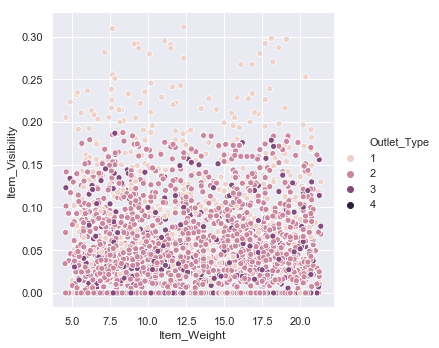

In [137]:
sns.relplot(x="Item_Weight", y="Item_Visibility",hue="Outlet_Type",  data=newData)

There is no such visible realtion between the item weight and item visibility, but we can observe the lare number of 0 in the item visibility whcih need to be adressed. also the mean replacement of the null values in item weight is also visible



By plotting the hue for Outlet_Type and Outlet_Location_type in the above plots we can observe the similarity in the points with visibility above 0.20 , we can observe that the points with hue corresponds to  Outlet_Type=1(Grocery_Store) are similar to points with points with hue for Outlet_Location_Type=3(Tier_3) which shows that most of the grocery stores are in the Tier_3 locations

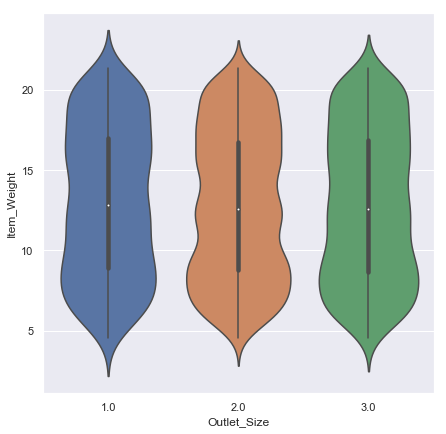

In [138]:
sns.violinplot(y="Item_Weight", x="Outlet_Size", data=newData)

{'Outlet_Size': {'High': 1, 'Medium': 2, 'Small': 3}}

we can observe that the items which were having missing values and are replaced by mode weight they are mostly in the outlets with size medium and small, while the outlets with large size do not have the missing weight thus have uniformly distributed item weights

# Item_Visibility

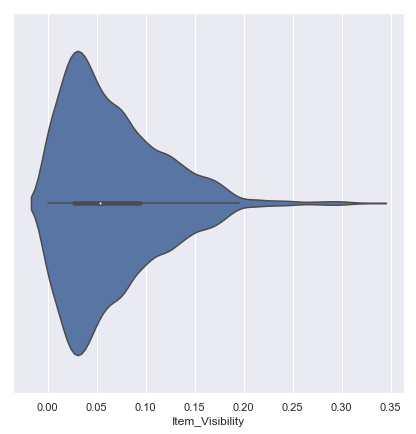

In [139]:

sns.violinplot(newData['Item_Visibility'])

The item Visibility distributio showing the lost of items with ) or very less visibility 

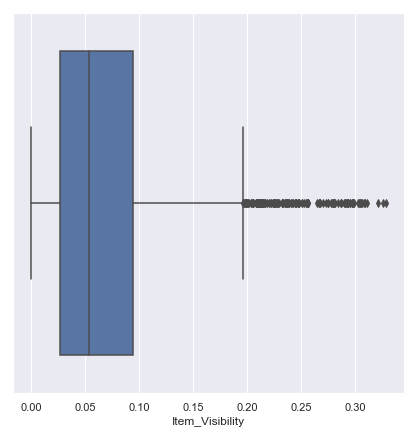

In [140]:
sns.boxplot(newData['Item_Visibility'])

The item visibility is skewed and we can observe the 0 visibility of large number of items, there are large number of outliers also observed in the item visibility due to skewness of the data. 

In [141]:
(newData.Item_Visibility==0).sum()

526

In [142]:
(newData.Item_Visibility>0.22).sum()

97

we have 526 items with zero item visibility. and approximately 97 outliers.


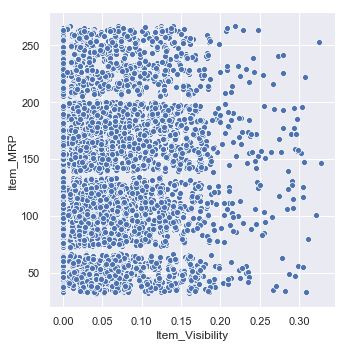

In [143]:
sns.relplot(x="Item_Visibility", y="Item_MRP", data=newData);

most of the items are having visibility 0 with some outliers and the mrp is showing no significant variation as the items with low visibility and high visibility both can have similar MRP
thus MRP of any item does not affect the visibility significantly 

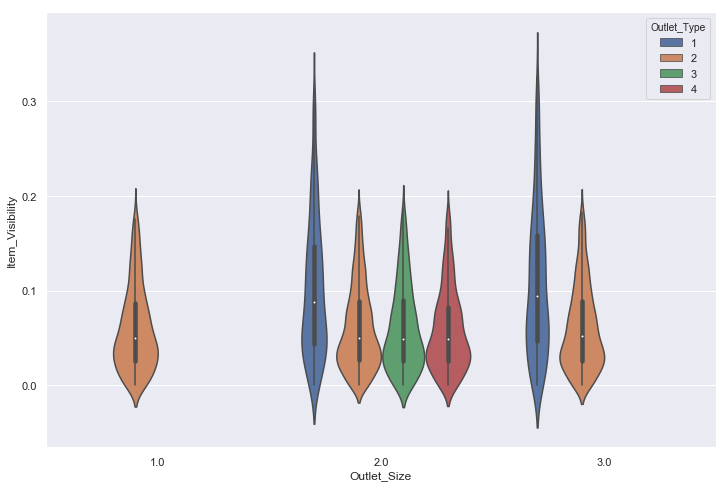

In [144]:
sns.set(rc={'figure.figsize':(12,8)})
sns.violinplot(y="Item_Visibility", x="Outlet_Size", hue="Outlet_Type", data=newData)

{'Outlet_Size': {'High': 1, 'Medium': 2, 'Small': 3}}

The outlet size also affects the  item visibility as we can observe tha the stores with size small ie 3 and 2 have the item visibility of some items in the higher range which corresponds due to the presenece of Outlet_Type =1 as all other Outlet_Types with Outket_Size (2 and 3 ) have visibility below 0.2.


The Outlet_Type =1 (Grocery_Store) have the highest Item_visbility, thus we can say that the Grocery_Store over all have more item_visibilty for all items as compared to other Outlet_types


Also we can observe by the hue of Outlet_type that Outlet_Size =1(High) have only one type of Outlet_Type =2(Supermarket_Type1)

Also the Outlet_Size =3 ie (Small) have no outlets of Outlet_Type(3,4) ie(Supermarket_Type2,Supermarket_Type3)

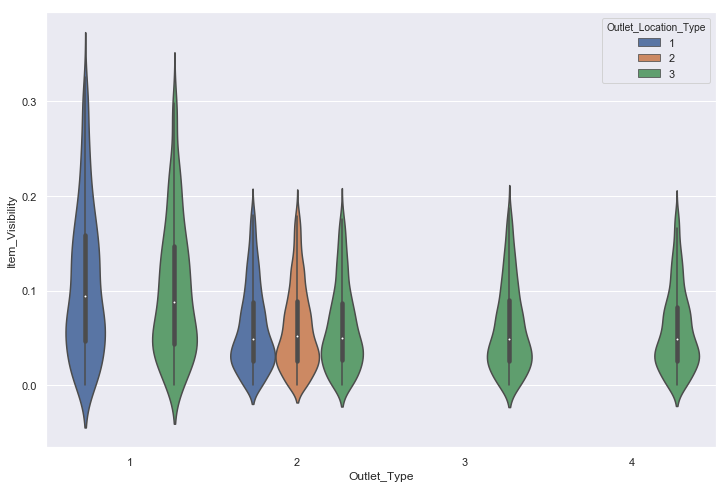

In [145]:
sns.violinplot(y="Item_Visibility", x="Outlet_Type",hue="Outlet_Location_Type", data=newData)

{'Outlet_Type': {'Grocery_Store': 1, 'Supermarket_Type1': 2, 'Supermarket_Type2': 3, 'Supermarket_Type3': 4}}
{'Outlet_Location_Type': {'Tier_1': 1, 'Tier_2': 2, 'Tier_3': 3}}


The item visibility also varies with outlet types , with Grocery_Store having the items with highest visibility, while all the supermarkets have lower item visibility as compared to the grocery store,

We can also observe that the Outlet_Type=3,4(Supermarket_Type2,Supermarket_Type3) are the only availabe in  Outlet_Location_Type=3(Tier_3)

Outlet_Type =1 (Grocery_Store) is not present in Tier_2 (Outlet_loaction_Type=2)


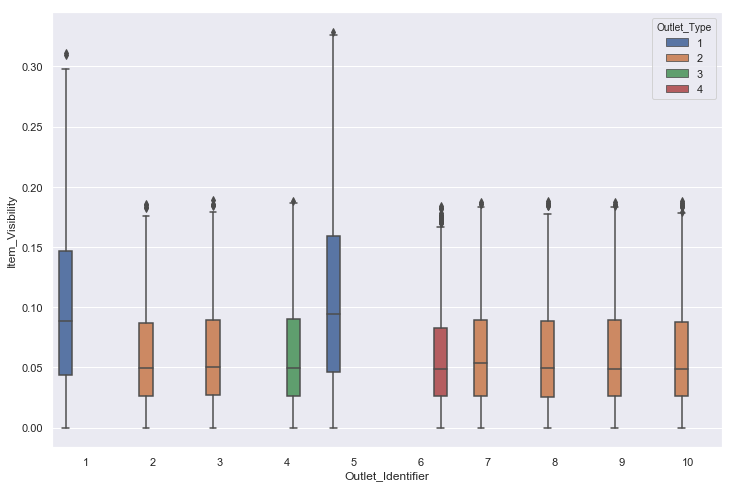

In [146]:
sns.boxplot(y="Item_Visibility", x="Outlet_Identifier",hue="Outlet_Type", data=newData)

Observing the item visibility trend of Outlet_Type and Outlet_Identifier With hue for Outlet_Type we can dettermine the corresponding Outlet_type

# Item type

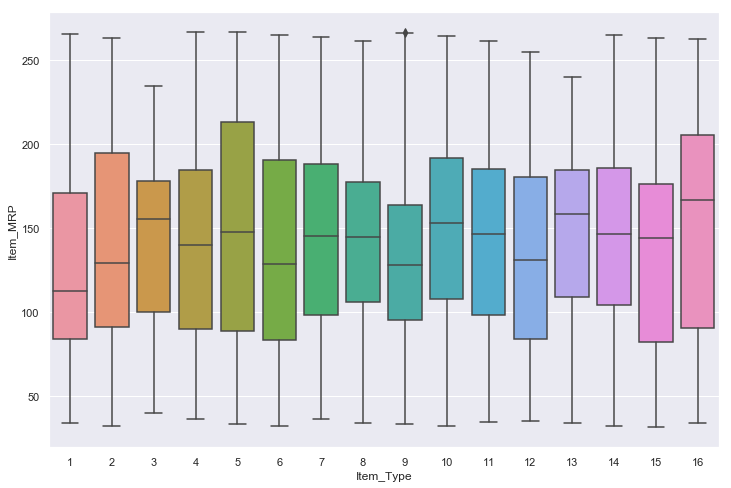

In [147]:
sns.boxplot(y="Item_MRP", x="Item_Type", data=newData)

The item types and thier Mrp distribution 

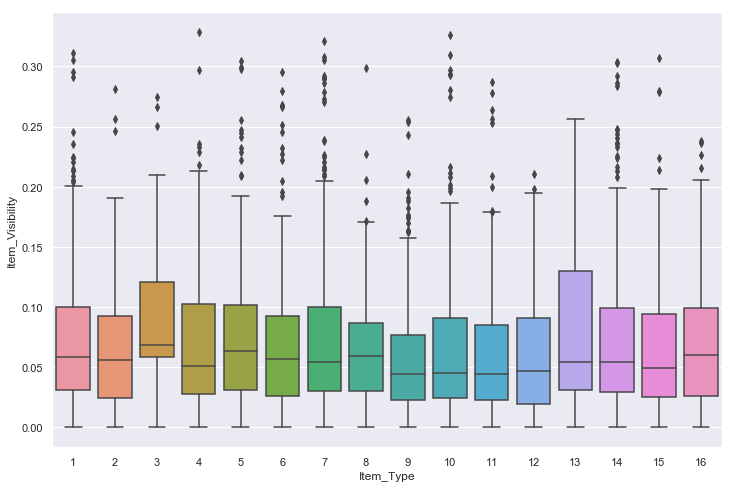

In [148]:
sns.boxplot(y="Item_Visibility", x="Item_Type", data=newData)

we can observe that the differnt items have different visibility distribution, as some have more visibility and some are having all items of that type in low visibility region, some items have visibility outliers which can be due to changw in the outlet type.

Text(0, 0.5, 'ietm type count')

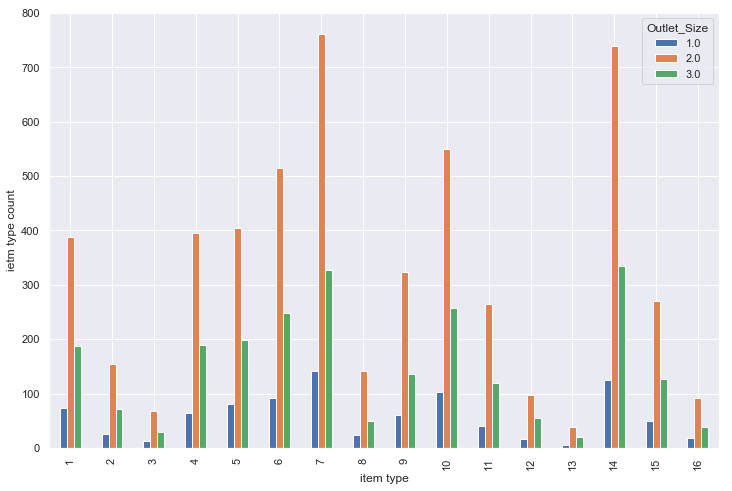

In [149]:
pd.crosstab(newData.Item_Type,newData.Outlet_Size).plot(kind='bar')
plt.xlabel('item type')
plt.ylabel('ietm type count')

Text(0, 0.5, 'ietm type count')

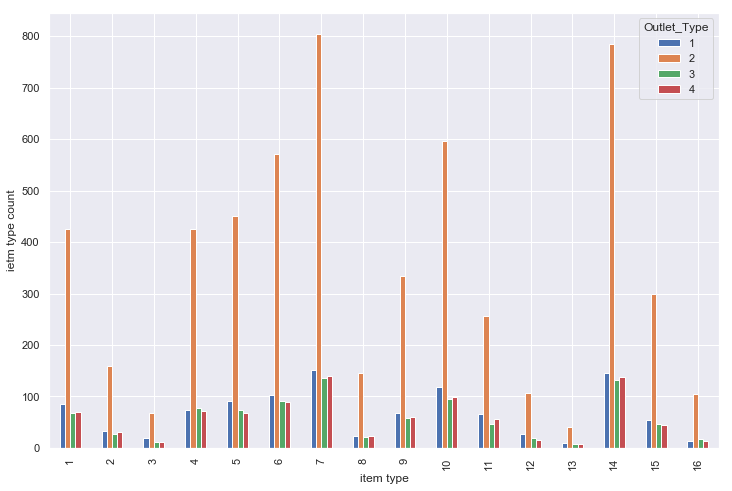

In [150]:
pd.crosstab(newData.Item_Type,newData.Outlet_Type).plot(kind='bar')
plt.xlabel('item type')
plt.ylabel('ietm type count')

Outlet_Size': {'High': 1, 'Medium': 2, 'Small': 3}

we obsere a trend in the availability of all the item types in the outlets based on size, the outlet size = medium have all the items in higher proportion as compared to outlet size small, but outlet size large have lesser item counts as compared to outlet size small


Comparing the Hue for Outlet_size and Outlet_type we can say that the Outlet_Type=2 (Supermarket_Type1) are having same distribution as Outlet_Size=2(Medium) thus the Supermarket_Type1 have medium Outlet_Size 

Text(0, 0.5, 'ietm type count')

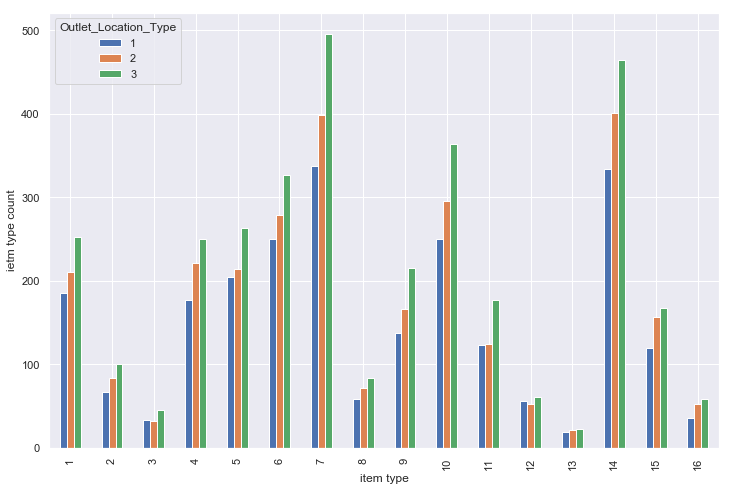

In [151]:
pd.crosstab(newData.Item_Type,newData.Outlet_Location_Type).plot(kind='bar')
plt.xlabel('item type')
plt.ylabel('ietm type count')

{'Outlet_Location_Type': {'Tier_1': 1, 'Tier_2': 2, 'Tier_3': 3}}

we can observe the trend of number of all items as all the outlet in tier_3 location have highest availabilty of the items (of all item types) 

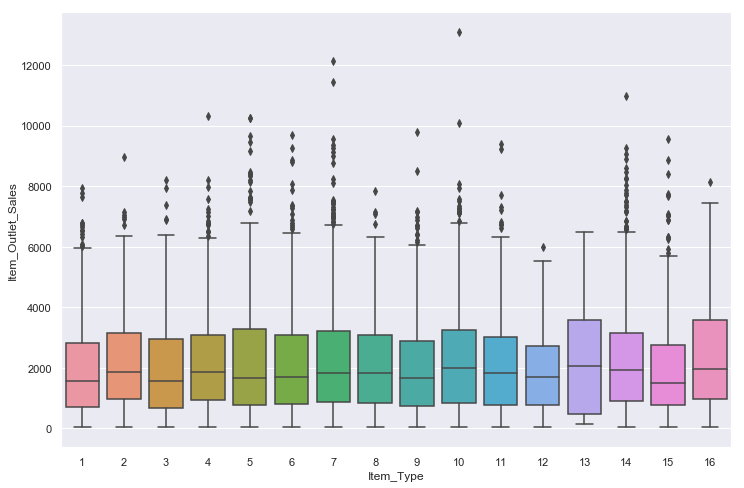

In [152]:
sns.boxplot(x="Item_Type", y="Item_Outlet_Sales",data=newData)
sns.set(rc={'figure.figsize':(10,15)})

The variation of item_outlet_sales of different item_types shows the variation of sales with item_type 7 and 10 showing the larget sales with outliers

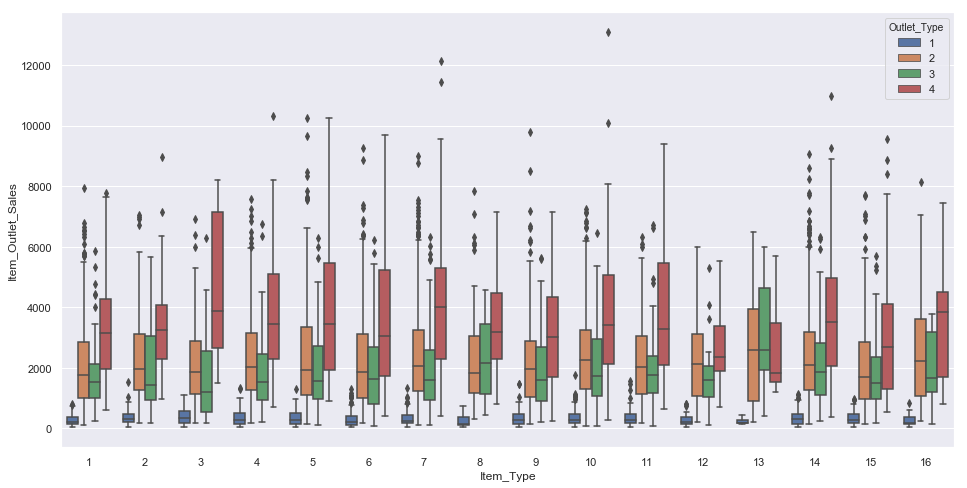

In [153]:
sns.set(rc={'figure.figsize':(16,8)})
sns.boxplot(x="Item_Type", y="Item_Outlet_Sales", hue="Outlet_Type",data=newData)


Observing the trend of the sales of different item types from differnt outlet_types  

Outlet_Type': {'Grocery_Store': 1, 'Supermarket_Type1': 2, 'Supermarket_Type2': 3, 'Supermarket_Type3': 4}}

the outlet_Type 1 is grocery store have the least sales of all the items (item_types) while the outlet_type_4(Supermarket_Type3) have the highest sales of all the item types


We observed earlier that the grocery_Store have the highest visibility items among all outlet_Type but we can see the sales are low as comapred to other Outlet_types (this can be due to the presence of large number of zero visibility items in grocery store

(array([ 59.,   0.,   0., 342.,   0.,   0.,  65.,   0.,   0.,  60.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

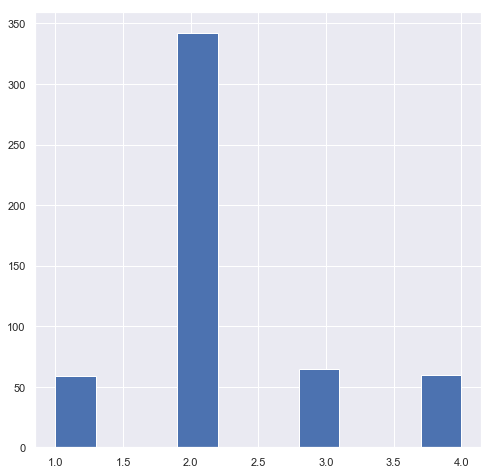

In [154]:
zero_visibility=newData[newData.Item_Visibility <=0]

#table[table.column_name == some_value]
sns.set(rc={'figure.figsize':(8,8)})
plt.hist(zero_visibility.Outlet_Type)

From above plot we can observe the proportions of items with zero visibilty among various Outlet_Type

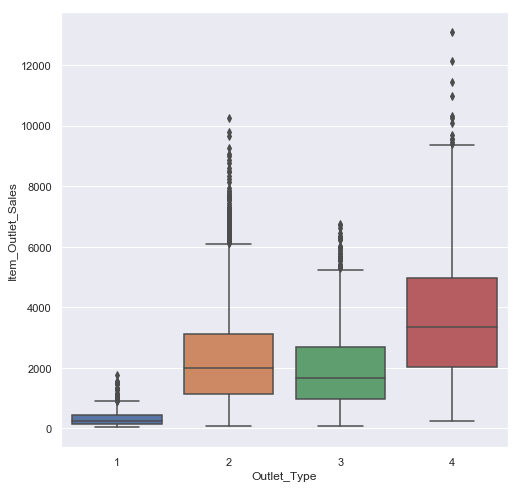

In [155]:
sns.boxplot(x="Outlet_Type", y="Item_Outlet_Sales",data=newData)

We can see the proportion of sales , which shows that the Outlet_type1 (grocery_store) have least sales of items and the Outlet_type=4 (Supermarket_Type3) have highest overall sales for products (all item types)

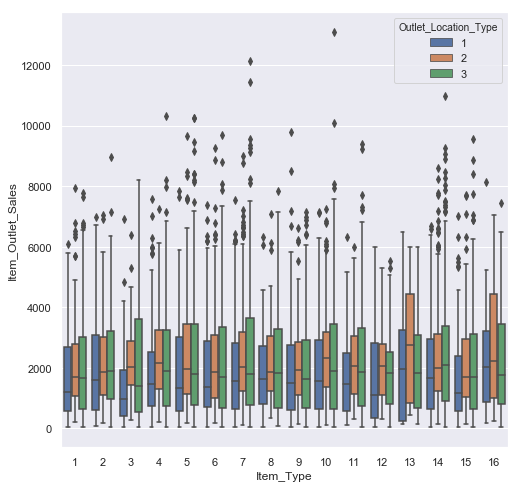

In [156]:
sns.boxplot(x="Item_Type", y="Item_Outlet_Sales", hue="Outlet_Location_Type",data=newData)
sns.set(rc={'figure.figsize':(20,20)})

Item sales for different item_types are not affected much by the outlet_location but we can observe that item_type 7, 10 shows outliers in sales 

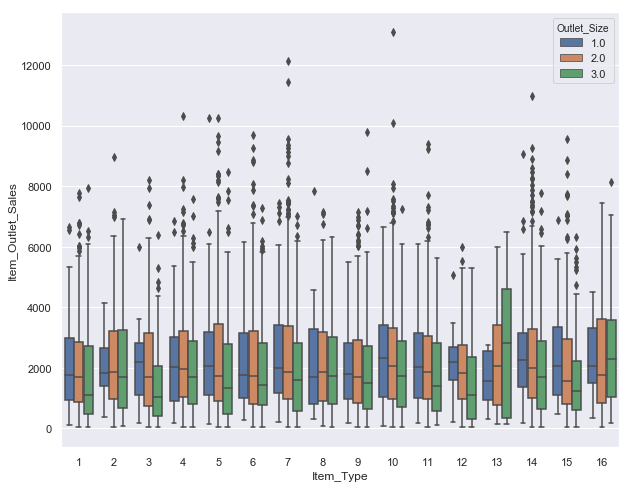

In [157]:
sns.set(rc={'figure.figsize':(10,8)})
sns.boxplot(x="Item_Type", y="Item_Outlet_Sales", hue="Outlet_Size",data=newData)


The Item sales for differnt Item_types shows a little variation based on outlet_size and here also we can observe the higher sales outliers of the item_type 7 and 10 as compared to other item_types which lies in the outlet_size =2(medium) with similar plots for outlet_location_type =3(tier_3)
which was observed above 

# Outlet_Identifier

In [158]:
sns.set(rc={'figure.figsize':(10,10)})

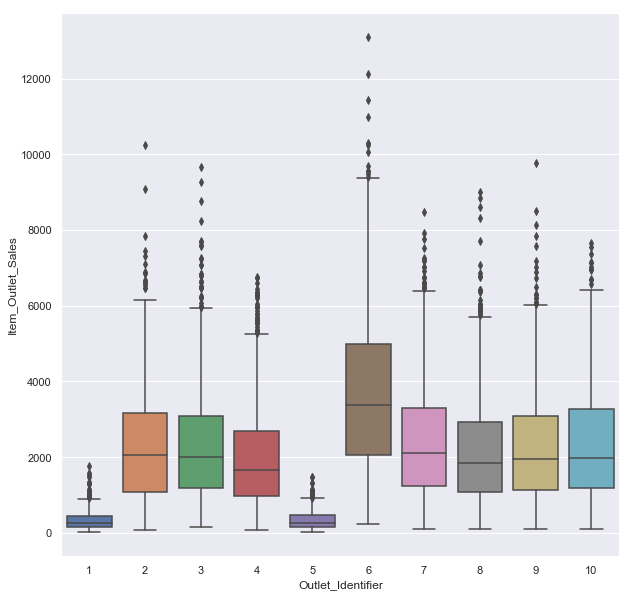

In [159]:
sns.boxplot(x="Outlet_Identifier", y="Item_Outlet_Sales",data=newData)


Outlet 1 and outlet 5 which corresponds to Outlet_type1( grocery store) have least numer of Item_outlet_sales among all the outlets 

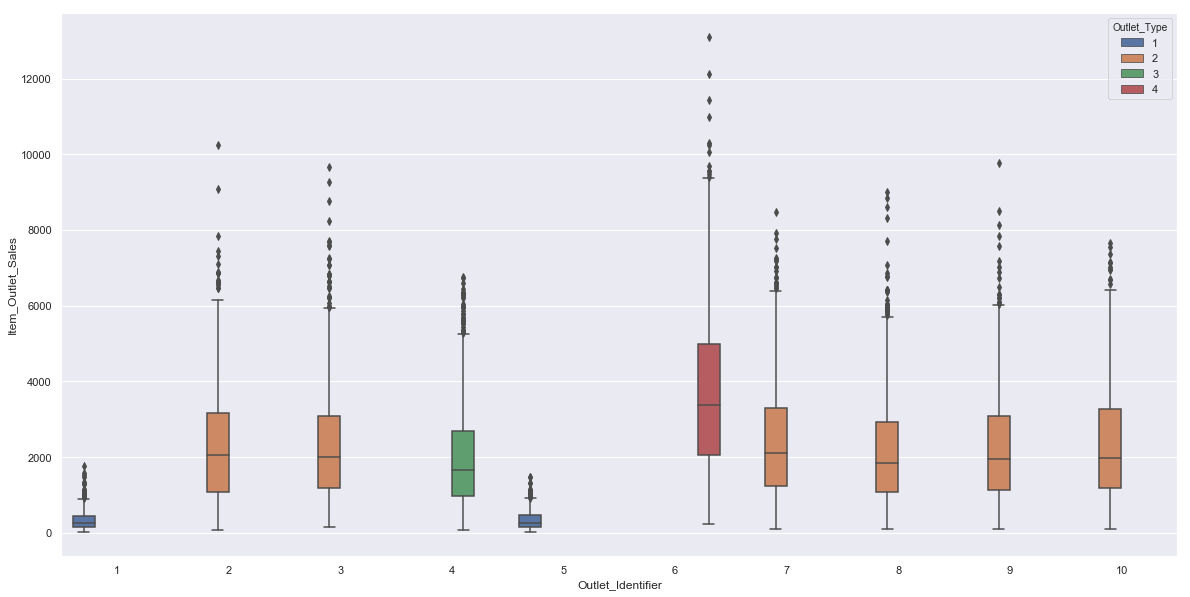

In [160]:
sns.set(rc={'figure.figsize':(20,10)})
sns.boxplot(x="Outlet_Identifier", y="Item_Outlet_Sales",hue="Outlet_Type",data=newData)

Different outlet_identifiers and thier corresponding Outlet_type ( we can observe the same relation we hypothesised in upper plot )

# Outlet_Size

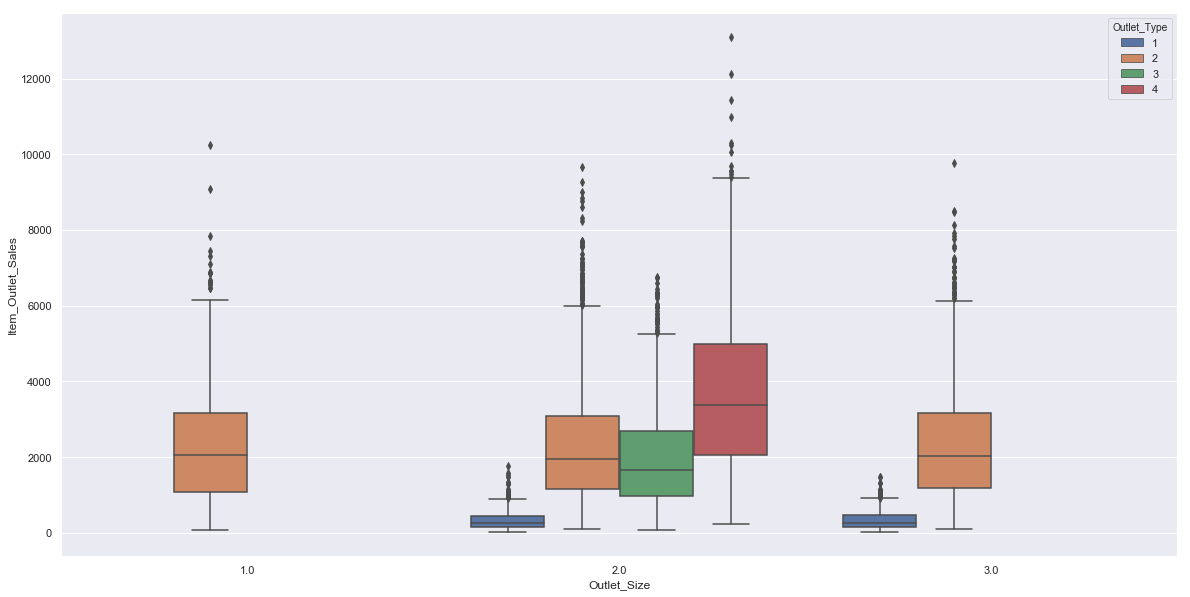

In [161]:
sns.boxplot(x="Outlet_Size", y="Item_Outlet_Sales",hue="Outlet_Type",data=newData)

# Item Sales 

In [162]:
newData.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

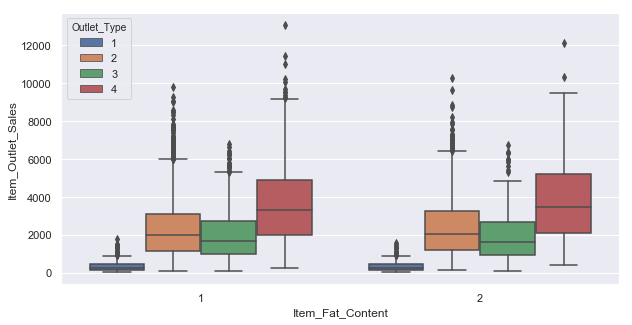

In [168]:
sns.set(rc={'figure.figsize':(10,5)})
sns.boxplot(x="Item_Fat_Content", y="Item_Outlet_Sales",hue="Outlet_Type",data=newData)

We can observe that the Item_Fat_content does not show any significant affect on sales as both of thw type have similar sales 

In [169]:
sns.set(rc={'figure.figsize':(7,7)})

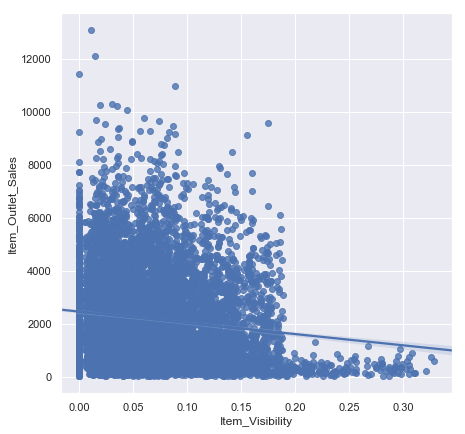

In [170]:
sns.regplot(x="Item_Visibility", y="Item_Outlet_Sales", data=newData)

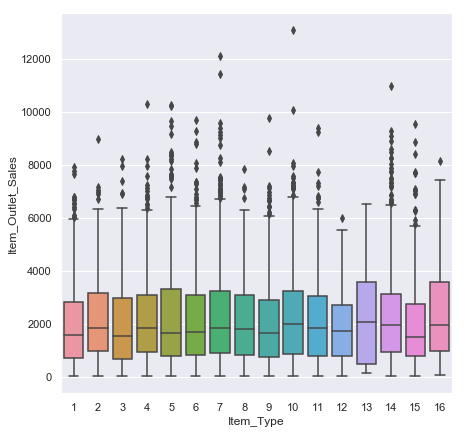

In [171]:
sns.boxplot(x="Item_Type", y="Item_Outlet_Sales",data=newData)

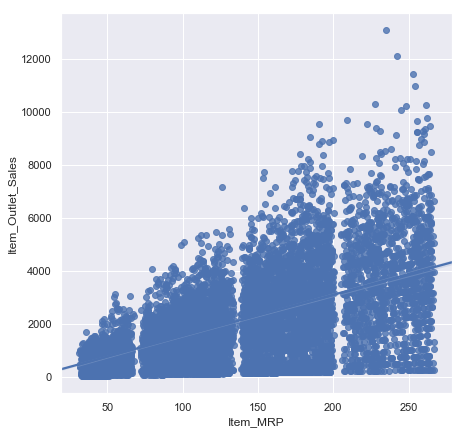

In [172]:
sns.regplot(x="Item_MRP", y="Item_Outlet_Sales", data=newData)

We can observe the relationship between the Item_MRP and Item_Outlet_sales as the sales are increasing linearly with MRP we can also observe some outliers which may affect the Regression 

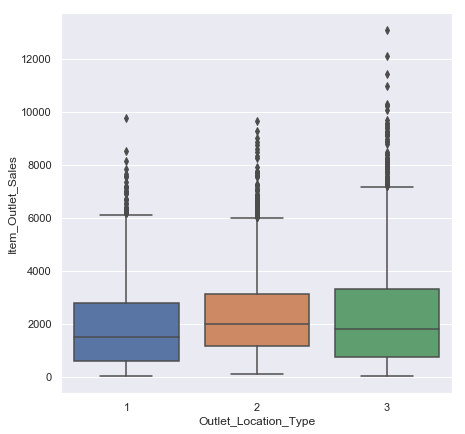

In [173]:
sns.boxplot(x="Outlet_Location_Type", y="Item_Outlet_Sales",data=newData)

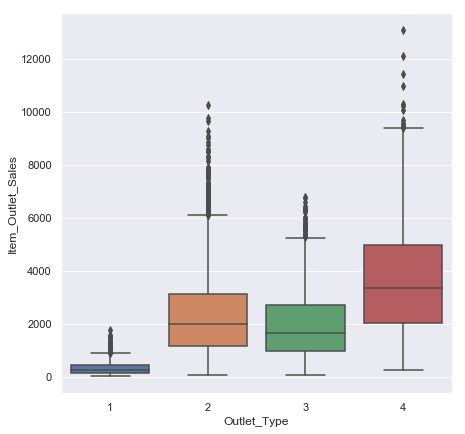

In [174]:
sns.boxplot(x="Outlet_Type", y="Item_Outlet_Sales",data=newData)

Outlet_Type certainly affects the sales which can be observed by the variation in the sales for different Outlet_types

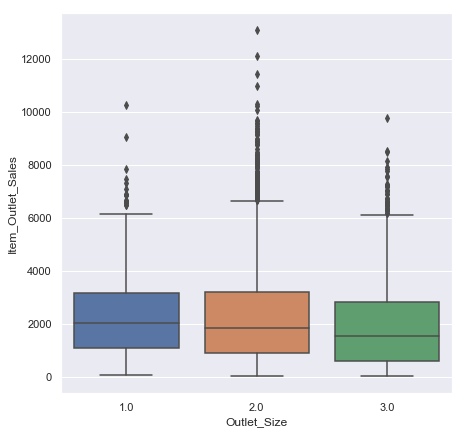

In [175]:
sns.boxplot(x="Outlet_Size", y="Item_Outlet_Sales",data=newData)

The sales are having outliers for Outlet_size =2 , nut all the other outlet_size have similar sales in the iqr

Now after observing the realtionship between the variables and observing the outliers we will do feature selection and build model to predict the sales 